# Phantom ->  Simulated CT -> CAD Pipeline

The purpose of this notebook is to display the whole pipeline for a single 5 mm slice.

### Phantom creation module

In [1]:
import insilicoICH
from insilicoICH import load_phantom
from image_utils import scrollview

age=0.0
seed=42
subtype='IPH'
volume=5
attenuation=50
if subtype == 'IPH':
    edema=5
else:
    edema=0

phantom = load_phantom(age)
phantom.insert_lesion(subtype, mass_effect=True, seed=seed, intensity=attenuation, volume=volume, edema=edema)

scrollview(phantom._phantom, display='soft tissues')

interactive(children=(IntSlider(value=90, description='idx', max=180), Output()), _dom_classes=('widget-intera…

# Scanner module

Initializing Scanner object...
----------
*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 1.0-mm pixels (XY), 1.0-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ncat_adipose', 'ncat_water', 'ncat_brain', 'ncat_skull']
* mu values (/cm): [0.18, 0.21, 0.21, 0.46]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.16, 0.2, 0.21, 0.27]
* Thresholds (HU): [-200.0, -10.0, 10.0, 300.0]
*********************************************
* Calculating volume fraction maps for 4 materials and 181 slices...
* Writing volume fraction files for 4 materials and 181 slices, plus the HU data...
* Writing /tmp/tmp9v3luw5l/0.0 yr UNC Head/

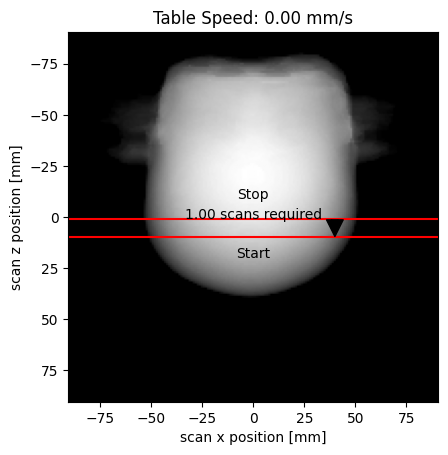

In [2]:
from insilicoICH import Scanner
scanner = Scanner(phantom, scanner_model='GE_Lightspeed16')

scans = 1
lesion_level_mm = (phantom.get_CT_number_phantom().shape[0]/2 - phantom._lesion_coords[0][0])*phantom.dz
center = lesion_level_mm
width = scanner.nominal_aperature*scans
print(width)
startZ = center - width / 2
endZ = center + width / 2

scanner.scout_view(startZ, endZ)

In [3]:
acquisition_technique = dict(
    mA=280,
    kVp=120,
    views=1000,
    startZ=startZ,
    endZ=endZ,
    pitch=0
)

scanner.run_scan(**acquisition_technique)

recon_technique = dict(
    kernel='standard',
    fov=250,
    sliceThickness=1 # 5mm slice thickness currently does not work as intended
)

scanner.run_recon(**recon_technique)

scrollview(scanner.recon, display='soft tissues')

scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/1000 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of    108 MB.


100%|██████████| 1000/1000 [05:38<00:00,  2.95it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...


interactive(children=(IntSlider(value=3, description='idx', max=6), Output()), _dom_classes=('widget-interact'…

# CAD module

/home/jayse.weaver/anaconda3/envs/insilicoCAD/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Model Output [0 to 1]:
EDH: 0.00443247752264142
IPH: 0.021912414580583572
IVH: 0.0010648947209119797
SAH: 0.011270329356193542
SDH: 0.02420377917587757
Any: 0.03192928433418274


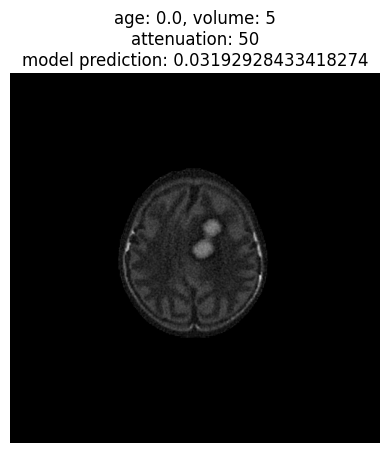

In [4]:
# Current model utilities are intended to work on saved DICOMs
# Some modifications here to work on already-loaded numpy arrays:
import numpy as np
import matplotlib.pyplot as plt
import model_utils
import albumentations as A
import cv2
import torch

labels = ['EDH', 'IPH', 'IVH', 'SAH', 'SDH', 'Any']

five_slice_vol = scanner.recon[-5:] # reduce recon slices to 5 1mm slices

image = np.mean(five_slice_vol, axis=0) # create average
plt.figure()
plt.imshow(image, vmin=0, vmax=80, cmap='gray')


# image preparation lifted from model_utils.prepare_images (intended for .dcm and .nii)
mean_img = [0.22363983, 0.18190407, 0.2523437 ]
std_img = [0.32451536, 0.2956294,  0.31335256]
transform = A.Normalize(mean=mean_img, std=std_img, max_pixel_value=255.0, p=1.0)

image = model_utils.apply_window_policy(image)
image -= image.min((0,1))
image = (255*image).astype(np.uint8)
#cv2.imwrite('test.jpg', image)
image = cv2.resize(image, (480, 480))
result = transform(image=image)
image = torch.from_numpy(result["image"])
image = torch.permute(image, (2, 1, 0)).unsqueeze(0)


# classify images
options = {'verbose': False}
model_path = '/home/jayse.weaver/model_files/CAD_1/'
output = model_utils.classify_images(image, options, model_path, device='cpu')

print('Model Output [0 to 1]:')
for idx, label in enumerate(labels):
    print(f'{label}: {output[0][idx]}')

plt.title(f'age: {age}, volume: {volume}\nattenuation: {attenuation}\nmodel prediction: {output[0][5]}')
plt.axis('off')
plt.show()
